In [33]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install gymnasium[other]
!pip install IPython

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video_html():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video).decode('ascii')
    ipythondisplay.display(HTML(data='<video controls src="data:video/x-m4v;base64,{0}">'.format(encoded)))
  else:
    print("Could not find video")

In [15]:
class Agent:

    def __init__(self):
        self.cumulative_reward = 0

    def step(self, action_space, observation):
        pass

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        self.cumulative_reward += immediate_reward

    def reset(self):
        print("Cumulative reward for this round:", self.cumulative_reward)
        self.cumulative_reward = 0


def run_episode(env, agent: Agent, show_video=False):
    observation, info = env.reset()
    cumulative_reward = 0
    while True:
        action = agent.step(env.action_space, observation)
        new_observation, reward, terminated, truncated, info  = env.step(action)
        if terminated:
            reward = -1
        agent.reward(reward, action, observation, new_observation)
        observation = new_observation
        if terminated or truncated:
            observation, info = env.reset()
            cumulative_reward += agent.cumulative_reward
            agent.reset()
            break
    if show_video:
        show_video_html()
    return cumulative_reward


In [3]:
import matplotlib.pyplot as plt

class RandomAgent(Agent):
    def step(self, action_space, observation):
        return action_space.sample()

episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
random_agent = RandomAgent()
for i in range(100):
    episode_results.append(run_episode(env, random_agent))



/home/ciyfhx/miniforge3/envs/ai/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/ciyfhx/SC3000/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Cumulative reward for this round: 15.0
Cumulative reward for this round: 28.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 16.0
Cumulative reward for this round: 9.0
Cumulative reward for this round: 14.0
Cumulative reward for this round: 41.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 13.0
Cumulative reward for this round: 16.0
Cumulative reward for this round: 59.0
Cumulative reward for this round: 33.0
Cumulative reward for this round: 17.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 12.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 32.0
Cumulative reward for this round: 20.0
Cumulative reward for this round: 26.0
Cumulative reward for this round: 25.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 19.0
Cumulative reward for this round: 31.0
Cumulative reward for this round: 10.0
Cumulative reward for this round: 31.0
Cumulative reward for this

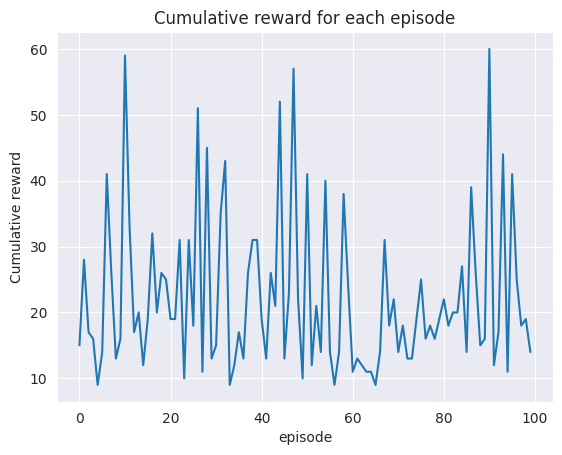

In [4]:
def show_result(episode_results):
    plt.plot(episode_results)
    plt.title('Cumulative reward for each episode')
    plt.ylabel('Cumulative reward')
    plt.xlabel('episode')
    plt.show()

show_result(episode_results)


Round: 0
Cumulative reward for this round: 48.0
Round: 1
Cumulative reward for this round: 15.0
Round: 2
Cumulative reward for this round: 8.0
Round: 3
Cumulative reward for this round: 14.0
Round: 4
Cumulative reward for this round: 19.0
Round: 5
Cumulative reward for this round: 35.0
Round: 6
Cumulative reward for this round: 14.0
Round: 7
Cumulative reward for this round: 28.0
Round: 8
Cumulative reward for this round: 9.0
Round: 9
Cumulative reward for this round: 26.0
Round: 10
Cumulative reward for this round: 10.0
Round: 11
Cumulative reward for this round: 7.0
Round: 12
Cumulative reward for this round: 20.0
Round: 13
Cumulative reward for this round: 20.0
Round: 14
Cumulative reward for this round: 23.0
Round: 15
Cumulative reward for this round: 14.0
Round: 16
Cumulative reward for this round: 21.0
Round: 17
Cumulative reward for this round: 20.0
Round: 18
Cumulative reward for this round: 22.0
Round: 19
Cumulative reward for this round: 8.0
Round: 20
Cumulative reward for th

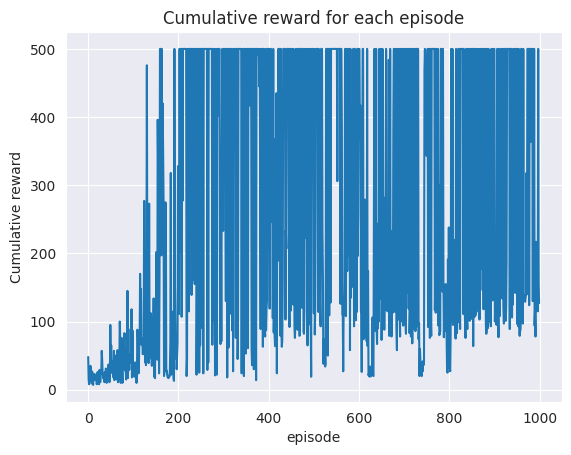

In [20]:
import numpy as np

# Model free
class QLearningControlAgent(Agent):

    def __init__(self,
        lower_bounds,
        upper_bounds,
        num_bins,
        num_action,
        min_epsilon=0.001, discount_factor=0.9, min_lr=0.1, decay=20,
    ):
        super().__init__()
        self.discount_factor = discount_factor
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.decay = decay
        self.t = 0
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.num_bins = np.array(num_bins)
        self.qtable = np.zeros(np.append(self.num_bins + 1, num_action))

    def to_discrete_state(self, observation):
        bin_window = (self.upper_bounds - self.lower_bounds) / self.num_bins
        clamped_observation = np.clip(observation, self.lower_bounds, self.upper_bounds)
        discrete_state = np.floor((clamped_observation - self.lower_bounds) / bin_window).astype(np.int32)
        return tuple(discrete_state)

    def get_learning_rate(self):
        return max(self.min_lr, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def get_epsilon(self):
        return max(self.min_epsilon, min(1., 1. - np.log10((self.t + 1) / self.decay)))

    def step(self, action_space, observation):
        state = self.to_discrete_state(observation)
        # Epsilon-greedy policy
        if np.random.random() < self.get_epsilon():
            action = np.random.randint(0, action_space.n)  # Random action
        else:
            action = np.argmax(self.qtable[state])  # Greedy action
        return action

    def reward(self, immediate_reward, prev_action, prev_observation, new_observation):
        super().reward(immediate_reward, prev_action, prev_observation, new_observation)
        prev_state = self.to_discrete_state(prev_observation)
        new_state = self.to_discrete_state(new_observation)
        self.qtable[prev_state + (prev_action,)] += self.get_learning_rate() * (immediate_reward + self.discount_factor * np.max(self.qtable[new_state]) - self.qtable[prev_state + (prev_action,)])

    def reset(self):
        super().reset()
        self.t += 1

episode_results = []
env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), "./videos")
upper_bounds = np.array([env.observation_space.high[0], 0.5, env.observation_space.high[2], np.radians(50) / 1.])
lower_bounds = np.array([env.observation_space.low[0], -0.5, env.observation_space.low[2], - np.radians(50) / 1.])
qlearning_agent = QLearningControlAgent(lower_bounds, upper_bounds, [3, 3, 6, 6], env.action_space.n)
for i in range(1000):
    print("Round: " + str(i))
    episode_results.append(run_episode(env, qlearning_agent))

show_result(episode_results)

In [ ]:
env